In [3]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, classification_report, precision_score, recall_score, accuracy_score, roc_auc_score 

 
from sklearn.preprocessing import StandardScaler


%matplotlib inline

# Load Dataset

In [4]:
loan = pd.read_csv(r'/home/jovyan/work/loan_table.csv', parse_dates=['date'])
loan.head()


,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


In [5]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   loan_id       101100 non-null  int64         
 1   loan_purpose  101100 non-null  object        
 2   date          101100 non-null  datetime64[ns]
 3   loan_granted  101100 non-null  int64         
 4   loan_repaid   47654 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 3.9+ MB


In [6]:
borrower = pd.read_csv(r'/home/jovyan/work/borrower_table.csv')
borrower.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


In [7]:
borrower.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 12 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   loan_id                                          101100 non-null  int64  
 1   is_first_loan                                    101100 non-null  int64  
 2   fully_repaid_previous_loans                      46153 non-null   float64
 3   currently_repaying_other_loans                   46153 non-null   float64
 4   total_credit_card_limit                          101100 non-null  int64  
 5   avg_percentage_credit_card_limit_used_last_year  94128 non-null   float64
 6   saving_amount                                    101100 non-null  int64  
 7   checking_amount                                  101100 non-null  int64  
 8   is_employed                                      101100 non-null  int64  
 9   yearly_salary  

# Data Processing

In [8]:
# merge loan and borrower information
data = pd.merge(left=loan, right=borrower, on='loan_id')

In [9]:
# choose data with loan granted 
# the data with loan not granted is not useful for profit calculation
data = data[data['loan_granted'] == 1]
data.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4
6,780070,business,2012-03-14,1,1.0,0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2
7,303138,emergency_funds,2012-08-31,1,0.0,0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2
8,91475,investment,2012-05-25,1,1.0,0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47654 entries, 3 to 101098
Data columns (total 16 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   loan_id                                          47654 non-null  int64         
 1   loan_purpose                                     47654 non-null  object        
 2   date                                             47654 non-null  datetime64[ns]
 3   loan_granted                                     47654 non-null  int64         
 4   loan_repaid                                      47654 non-null  float64       
 5   is_first_loan                                    47654 non-null  int64         
 6   fully_repaid_previous_loans                      21865 non-null  float64       
 7   currently_repaying_other_loans                   21865 non-null  float64       
 8   total_credit_card_limit            

In [11]:
# check missing values
missing = data.isnull().sum()
missing[missing > 0]

fully_repaid_previous_loans                        25789
currently_repaying_other_loans                     25789
avg_percentage_credit_card_limit_used_last_year      903
dtype: int64

Now, after removing the data with `loan` not granted, our goal is to predict whether or not the user is going to repay the loan. 

In [12]:
# parse date information and extract month, week, and dayofweek information
data['month'] = data['date'].apply(lambda x: x.month)
data['week'] = data['date'].apply(lambda x: x.week)
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)

# drop useless features
data = data.drop(labels=['loan_id', 'date', 'loan_granted'], axis=1, inplace=False)

# Visualization

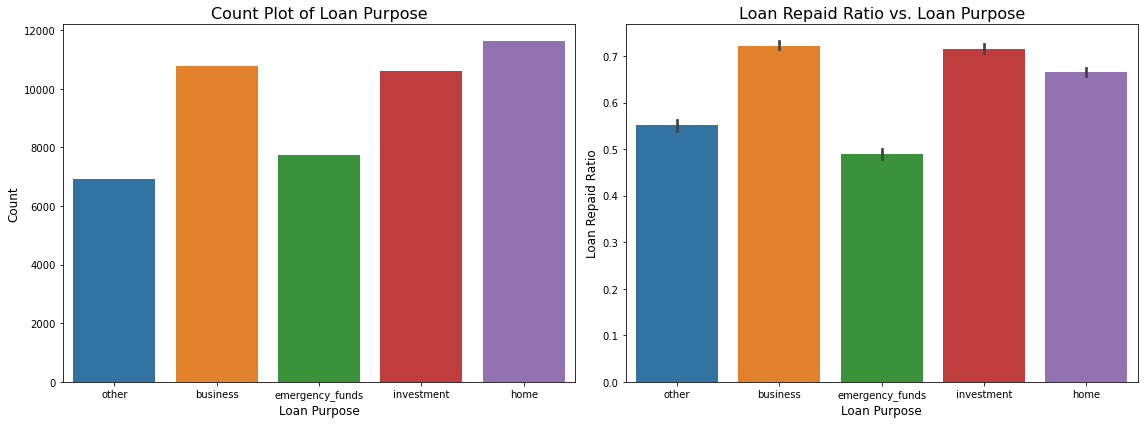

In [13]:
# visualization of 'loan_purpose'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='loan_purpose', data=data, ax=ax[0])
ax[0].set_xlabel('Loan Purpose', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Loan Purpose', fontsize=16)

sns.barplot(x='loan_purpose', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('Loan Purpose', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. Loan Purpose', fontsize=16)
plt.tight_layout()
plt.show()

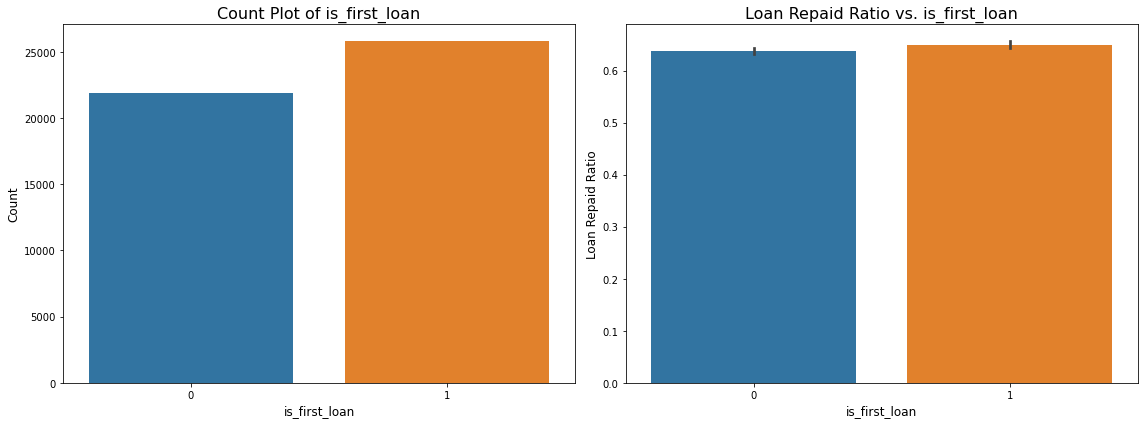

In [12]:
# visualization of 'is_first_loan'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='is_first_loan', data=data, ax=ax[0])
ax[0].set_xlabel('is_first_loan', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of is_first_loan', fontsize=16)

sns.barplot(x='is_first_loan', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('is_first_loan', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. is_first_loan', fontsize=16)
plt.tight_layout()
plt.show()

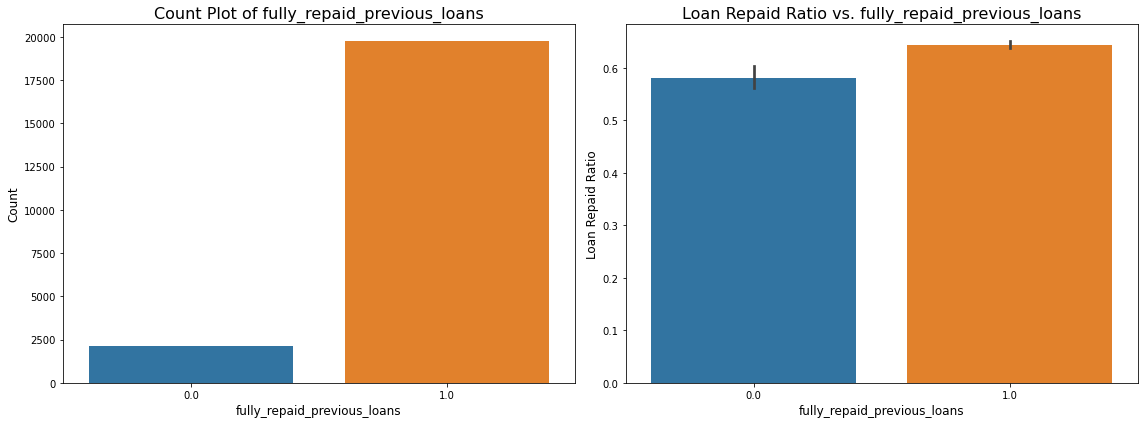

In [13]:
# visualization of 'fully_repaid_previous_loans'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='fully_repaid_previous_loans', data=data, ax=ax[0])
ax[0].set_xlabel('fully_repaid_previous_loans', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of fully_repaid_previous_loans', fontsize=16)

sns.barplot(x='fully_repaid_previous_loans', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('fully_repaid_previous_loans', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. fully_repaid_previous_loans', fontsize=16)
plt.tight_layout()
plt.show()

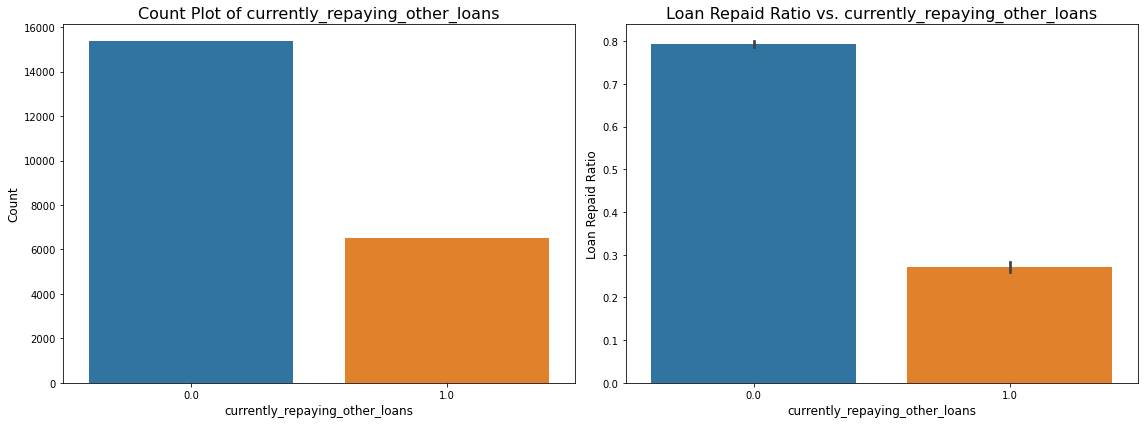

In [14]:
# visualization of 'currently_repaying_other_loans'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='currently_repaying_other_loans', data=data, ax=ax[0])
ax[0].set_xlabel('currently_repaying_other_loans', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of currently_repaying_other_loans', fontsize=16)

sns.barplot(x='currently_repaying_other_loans', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('currently_repaying_other_loans', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. currently_repaying_other_loans', fontsize=16)
plt.tight_layout()
plt.show()

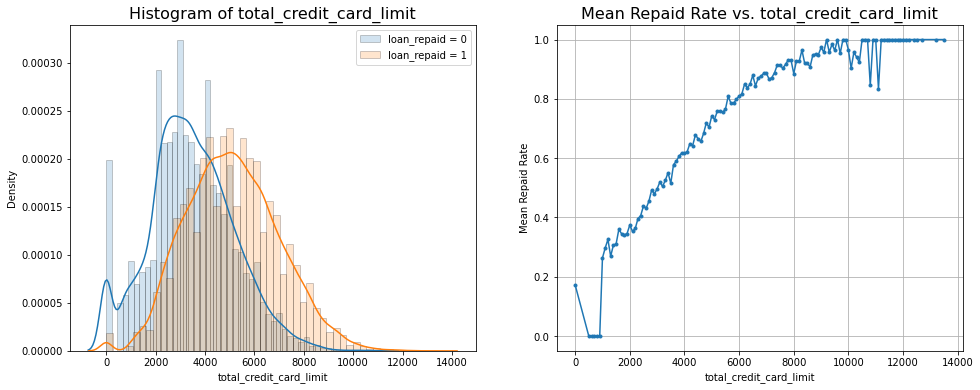

In [15]:
# Visualization of 'total_credit_card_limit'
grouped = data[['total_credit_card_limit', 'loan_repaid']].groupby('total_credit_card_limit')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['total_credit_card_limit'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['total_credit_card_limit'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of total_credit_card_limit', fontsize=16)
ax[0].legend()
ax[1].plot(mean['total_credit_card_limit'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. total_credit_card_limit', fontsize=16)
ax[1].set_xlabel('total_credit_card_limit')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

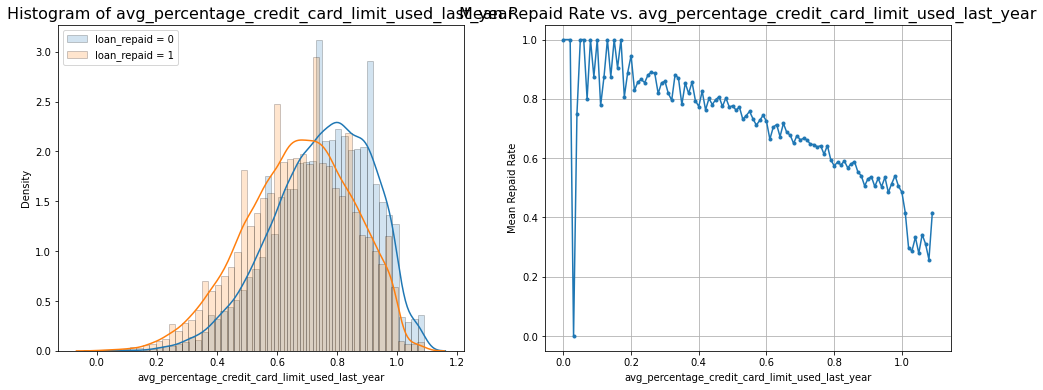

In [16]:
# Visualization of 'avg_percentage_credit_card_limit_used_last_year'
not_null = data[~data['avg_percentage_credit_card_limit_used_last_year'].isnull()]
grouped = not_null.groupby('avg_percentage_credit_card_limit_used_last_year')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(not_null[not_null['loan_repaid'] == 0]['avg_percentage_credit_card_limit_used_last_year'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(not_null[not_null['loan_repaid'] == 1]['avg_percentage_credit_card_limit_used_last_year'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of avg_percentage_credit_card_limit_used_last_year', fontsize=16)
ax[0].legend()
ax[1].plot(mean['avg_percentage_credit_card_limit_used_last_year'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. avg_percentage_credit_card_limit_used_last_year', fontsize=16)
ax[1].set_xlabel('avg_percentage_credit_card_limit_used_last_year')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

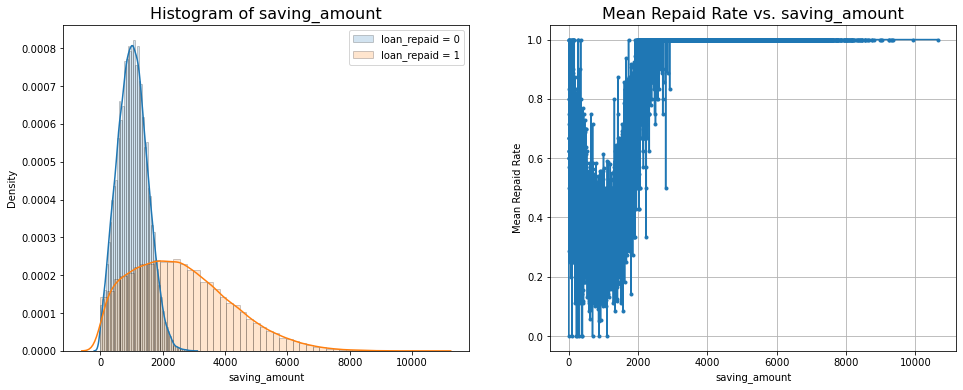

In [17]:
# Visualization of 'saving_amount'
grouped = data[['saving_amount', 'loan_repaid']].groupby('saving_amount')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['saving_amount'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['saving_amount'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of saving_amount', fontsize=16)
ax[0].legend()
ax[1].plot(mean['saving_amount'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. saving_amount', fontsize=16)
ax[1].set_xlabel('saving_amount')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

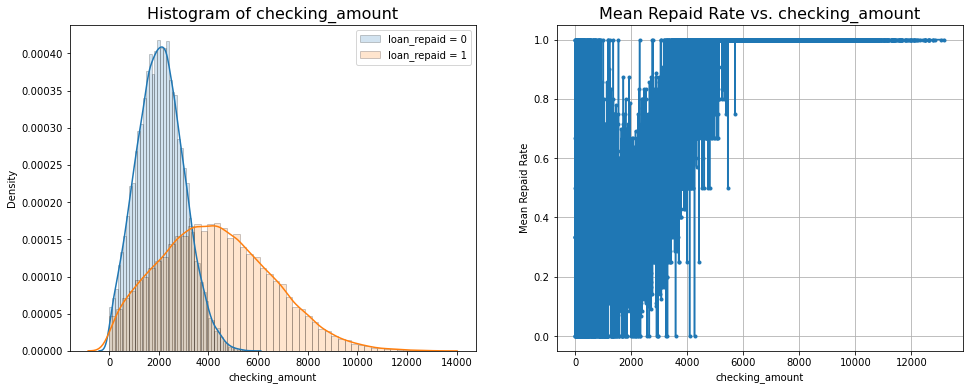

In [18]:
# Visualization of 'checking_amount'
grouped = data[['checking_amount', 'loan_repaid']].groupby('checking_amount')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['checking_amount'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['checking_amount'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of checking_amount', fontsize=16)
ax[0].legend()
ax[1].plot(mean['checking_amount'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. checking_amount', fontsize=16)
ax[1].set_xlabel('checking_amount')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

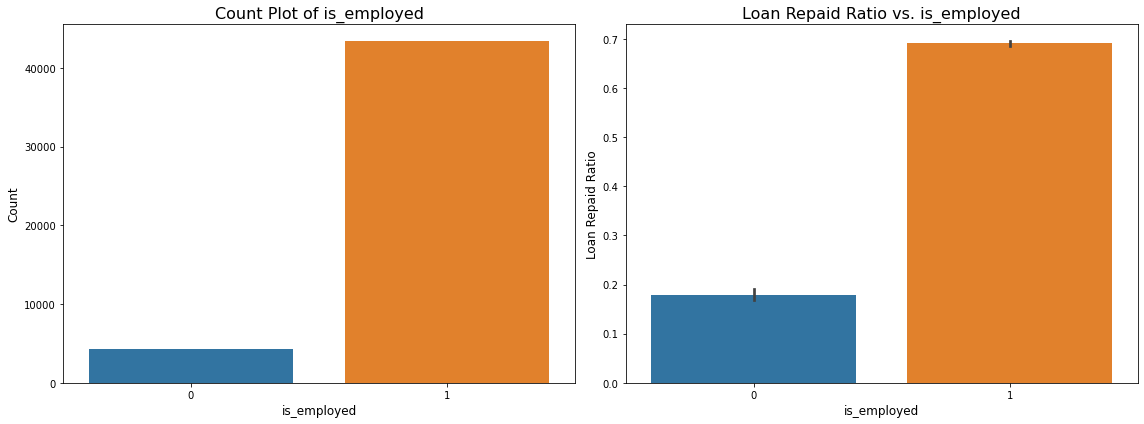

In [19]:
# visualization of 'is_employed'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='is_employed', data=data, ax=ax[0])
ax[0].set_xlabel('is_employed', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of is_employed', fontsize=16)

sns.barplot(x='is_employed', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('is_employed', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. is_employed', fontsize=16)
plt.tight_layout()
plt.show()

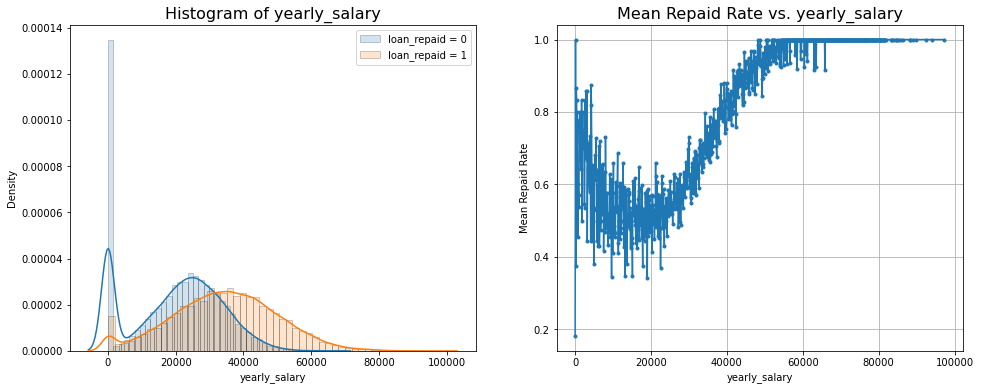

In [20]:
# Visualization of 'yearly_salary'
grouped = data[['yearly_salary', 'loan_repaid']].groupby('yearly_salary')
mean = grouped.mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(data[data['loan_repaid'] == 0]['yearly_salary'], 
             label='loan_repaid = 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid'] == 1]['yearly_salary'], 
             label='loan_repaid = 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Histogram of yearly_salary', fontsize=16)
ax[0].legend()
ax[1].plot(mean['yearly_salary'], mean['loan_repaid'], '.-')
ax[1].set_title('Mean Repaid Rate vs. yearly_salary', fontsize=16)
ax[1].set_xlabel('yearly_salary')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

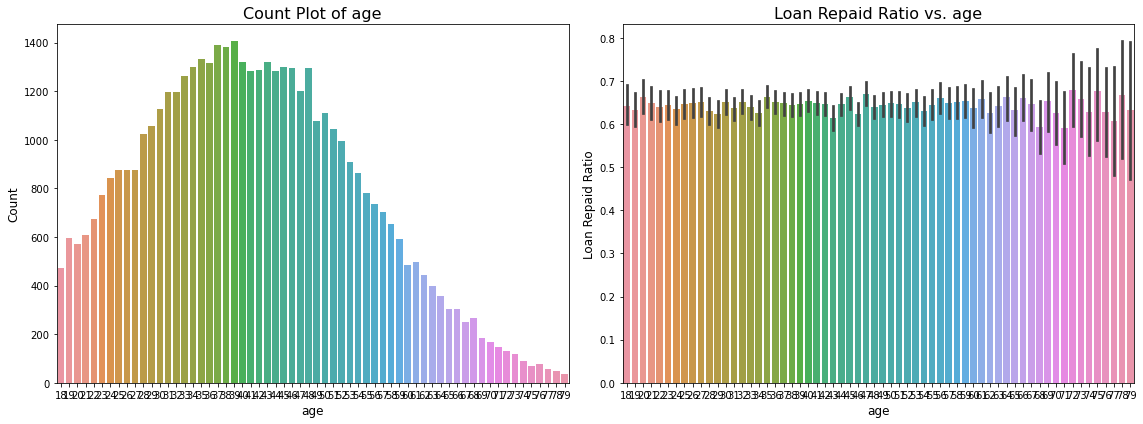

In [21]:
# visualization of 'age'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='age', data=data, ax=ax[0])
ax[0].set_xlabel('age', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of age', fontsize=16)

sns.barplot(x='age', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('age', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. age', fontsize=16)
plt.tight_layout()
plt.show()

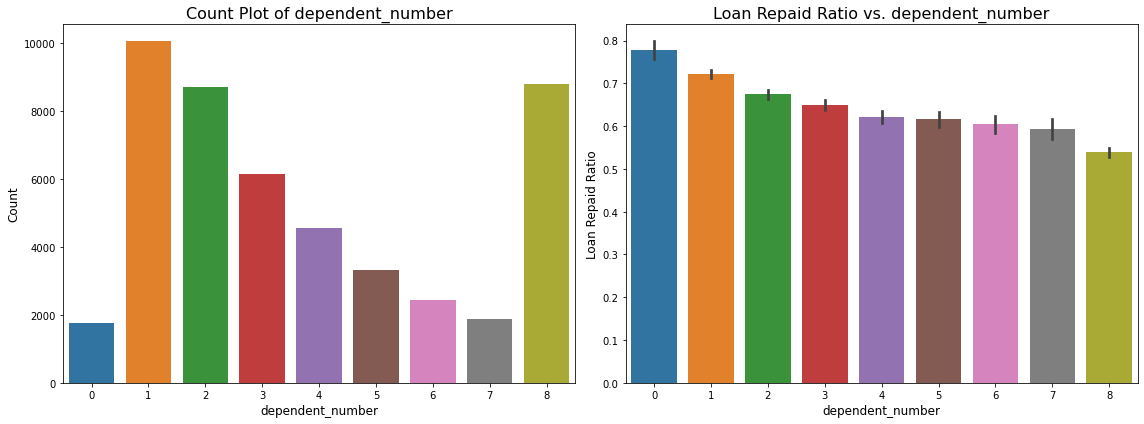

In [22]:
# visualization of 'age'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='dependent_number', data=data, ax=ax[0])
ax[0].set_xlabel('dependent_number', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of dependent_number', fontsize=16)

sns.barplot(x='dependent_number', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('dependent_number', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. dependent_number', fontsize=16)
plt.tight_layout()
plt.show()

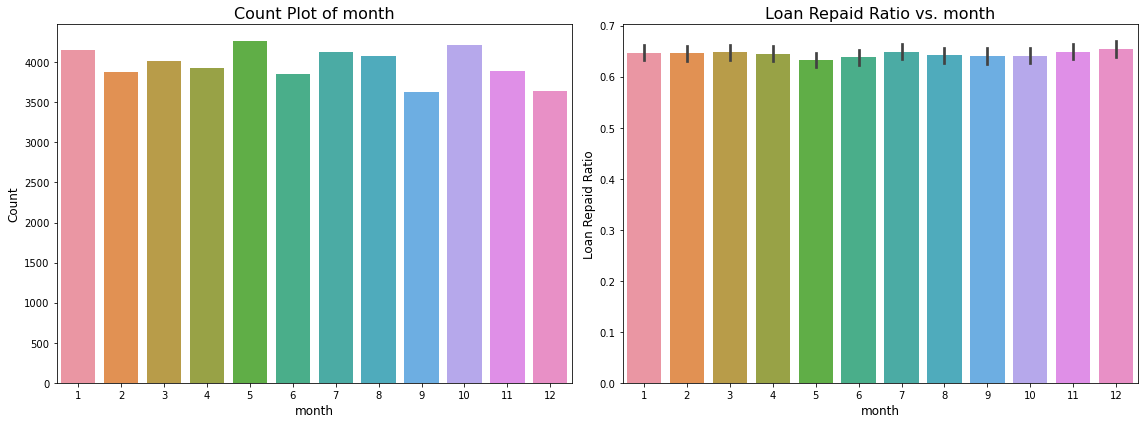

In [23]:
# visualization of 'month'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='month', data=data, ax=ax[0])
ax[0].set_xlabel('month', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of month', fontsize=16)

sns.barplot(x='month', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('month', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. month', fontsize=16)
plt.tight_layout()
plt.show()

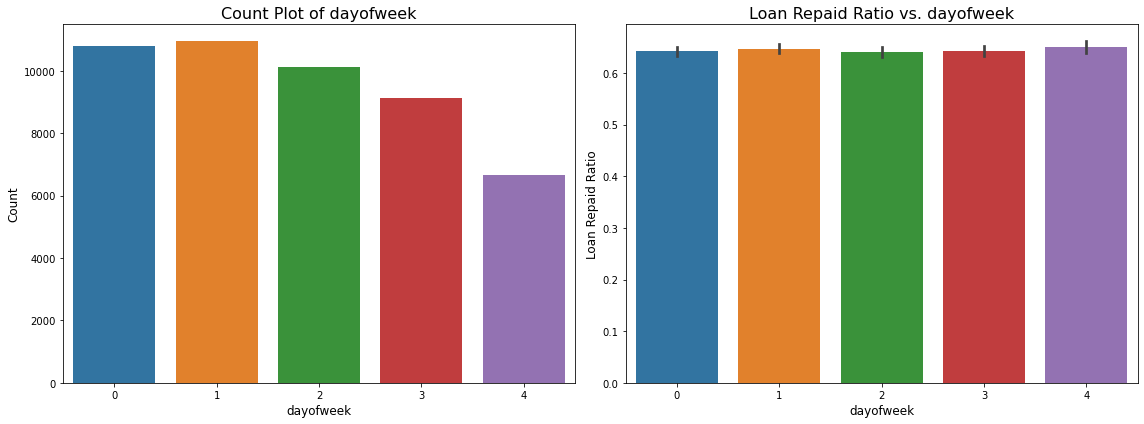

In [24]:
# visualization of 'dayofweek'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='dayofweek', data=data, ax=ax[0])
ax[0].set_xlabel('dayofweek', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of dayofweek', fontsize=16)

sns.barplot(x='dayofweek', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('dayofweek', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. dayofweek', fontsize=16)
plt.tight_layout()
plt.show()

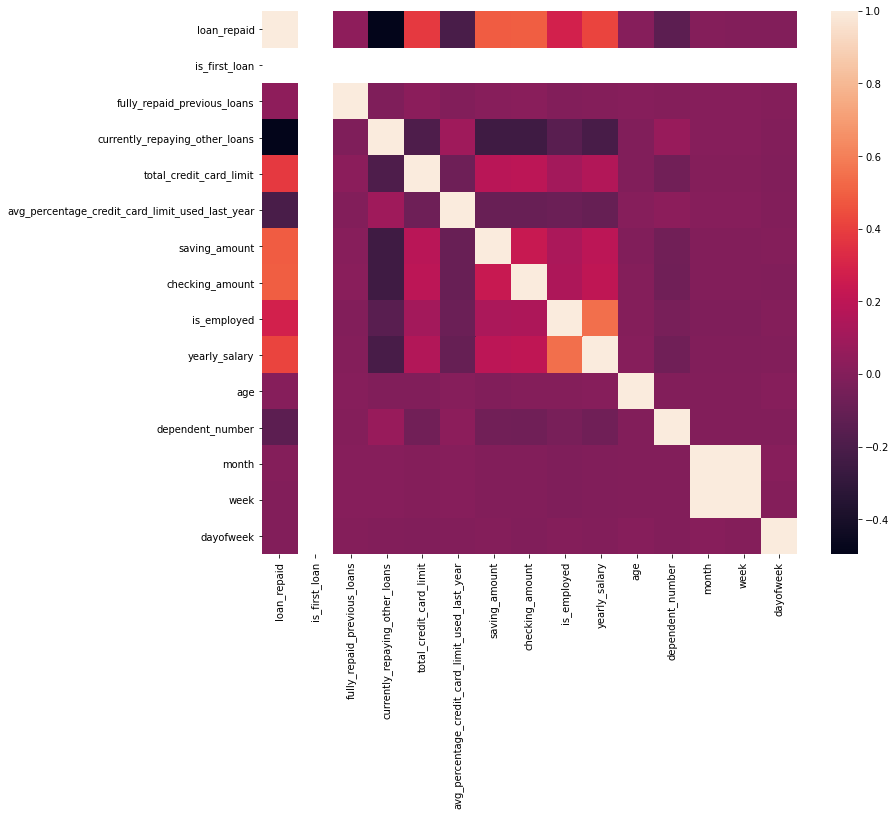

In [25]:
# feature correlation
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(data.dropna(axis=0, how='any').corr(), ax=ax)
plt.show()

# Feature Engineering

### 1. `fully_repaid_previous_loans` and `currently_repaying_other_loans`

In [14]:
# there is a clear connection between 'is_first_loan' 
# and 'fully_repaid_previous_loans', 'currently_repaying_other_loans'
print(data[data['is_first_loan'] == 1]['fully_repaid_previous_loans'].unique())
print(data[data['is_first_loan'] == 1]['currently_repaying_other_loans'].unique())

[nan]
[nan]


In [15]:
# fill missing values with -1 for 'fully_repaid_previous_loans' and 'currently_repaying_other_loans'
data = data.fillna({'fully_repaid_previous_loans': -1, 'currently_repaying_other_loans': -1})

### 2. `avg_percentage_credit_card_limit_used_last_year`

In [16]:
# fill missing values with median
median = data['avg_percentage_credit_card_limit_used_last_year'].median()
data = data.fillna({'avg_percentage_credit_card_limit_used_last_year': median})

In [17]:
# drop useless features
data = data.drop(labels=['month', 'week', 'dayofweek'], axis=1, inplace=False)

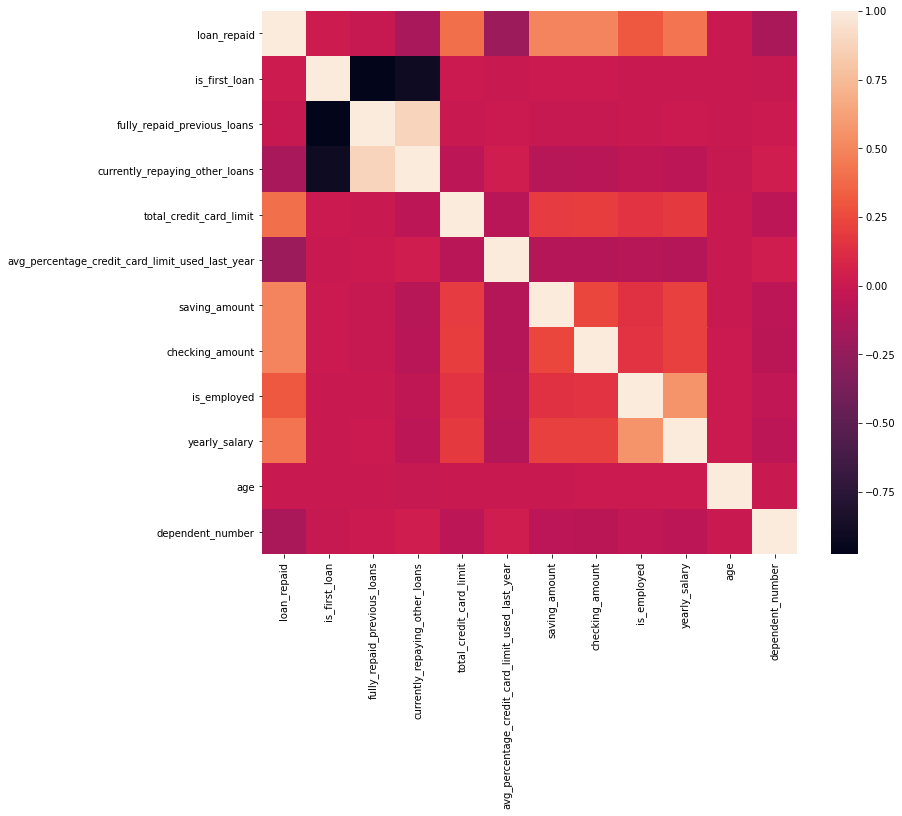

In [18]:
# feature correlation
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(data.corr(), ax=ax)
plt.show()

# Machine Learning

Here, I will try to implement the quite new package called LightGBM.

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47654 entries, 3 to 101098
Data columns (total 13 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   loan_purpose                                     47654 non-null  object 
 1   loan_repaid                                      47654 non-null  float64
 2   is_first_loan                                    47654 non-null  int64  
 3   fully_repaid_previous_loans                      47654 non-null  float64
 4   currently_repaying_other_loans                   47654 non-null  float64
 5   total_credit_card_limit                          47654 non-null  int64  
 6   avg_percentage_credit_card_limit_used_last_year  47654 non-null  float64
 7   saving_amount                                    47654 non-null  int64  
 8   checking_amount                                  47654 non-null  int64  
 9   is_employed                

In [20]:
# encoding 'loan_purpose'
encoder = LabelEncoder()
data['loan_purpose'] = encoder.fit_transform(data['loan_purpose'])

In [21]:
data.head()


,loan_purpose,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
3,4,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,0,0.0,1,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4
6,0,1.0,0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2
7,1,0.0,0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2
8,3,1.0,0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1


In [22]:
# split into training and test data set
X = data.drop('loan_repaid', axis=1)
y = data['loan_repaid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

train_matrix = xgb.DMatrix(X_train,y_train)
test_matrix = xgb.DMatrix(X_test)

In [35]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
from xgboost import plot_importance


params = {'booster':'gbtree','objective': 'binary:logistic','colsample_bytree': 0.8,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv(dtrain=train_matrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=30,metrics='auc', as_pandas=True, seed=123)

n_best_trees = cv_results.shape[0]
print("best number of trees: {}".format(n_best_trees))  # output 53

watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)  #打印错误率，准确率=1-错误率


best number of trees: 50
[0]	train-error:0.11419
[1]	train-error:0.11052
[2]	train-error:0.10330
[3]	train-error:0.09575
[4]	train-error:0.08884
[5]	train-error:0.08668
[6]	train-error:0.08629
[7]	train-error:0.08570
[8]	train-error:0.08637
[9]	train-error:0.08651
[10]	train-error:0.08539
[11]	train-error:0.08551
[12]	train-error:0.08416
[13]	train-error:0.08456
[14]	train-error:0.08442
[15]	train-error:0.08310
[16]	train-error:0.08310
[17]	train-error:0.08304
[18]	train-error:0.08223
[19]	train-error:0.08254
[20]	train-error:0.08243
[21]	train-error:0.08226
[22]	train-error:0.08139
[23]	train-error:0.08137
[24]	train-error:0.08083
[25]	train-error:0.08089
[26]	train-error:0.08086
[27]	train-error:0.08053
[28]	train-error:0.08019
[29]	train-error:0.07977
[30]	train-error:0.07969
[31]	train-error:0.07946
[32]	train-error:0.07918
[33]	train-error:0.07927
[34]	train-error:0.07918
[35]	train-error:0.07871
[36]	train-error:0.07840
[37]	train-error:0.07851
[38]	train-error:0.07820
[39]	train

In [ ]:
xgb.plot_importance(gbt)

In [ ]:
#Plotting ROC curve
def validation_roc():
    train_features1,valid_features,train_target1,valid_target = train_test_split(X_train,y_train,test_size=0.2,random_state=3)
    
    train_data = xgb.DMatrix(train_features1,train_target1)
    valid_data = xgb.DMatrix(valid_features)
 
    
    # retrain on training set
    xgb_train = xgb.train(params, train_data, n_best_trees)
    
    # predict on validation set
    valid_probas = xgb_train.predict(valid_data, ntree_limit=n_best_trees)
    
    d = {}
    d['FPR'],d['TPR'],d['Threshold'] = roc_curve(valid_target,valid_probas)
    return pd.DataFrame(d)

roc_results = validation_roc()

_ = plt.figure()
plt.plot(roc_results.FPR,roc_results.TPR)
plt.xlabel("FPR")
plt.ylabel('TPR')

roc_results.loc[(roc_results.TPR > 0.6) & (roc_results.TPR < 0.65),:]

In [30]:
# re-train the model and make predictions
import sklearn.linear_model as sk
    
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

    
LR=sk.LogisticRegressionCV(cv=5, random_state=0)
lrmodel=LR.fit(X_train,y_train)

lrpred=lrmodel.predict(X_test)  #predicted laber on test dataset
lrpred_prob=lrmodel.predict_proba(X_test)[:,1]  #predicted probability on test dataset
print(lrmodel.coef_)

print(accuracy_score(y_test,lrpred))
print(precision_score(y_test,lrpred))
print(roc_auc_score(y_test,lrpred_prob))
    
 


[[-0.07578293 -0.95185784  0.43932203 -1.50908458  0.99572729 -0.43358825
   2.17645715  1.8069498   0.03703474  1.09377572  0.00520577 -0.25353697]]
0.9016283364109451
0.9284679225398498
0.9636264743663113


# Questions

### Question 1

In [100]:
# Total profit from original bank:
loan_paid = y_test.astype(int).values
bank_profit = np.sum(loan_paid * 2 - 1)
print('Bank profit:\t', bank_profit)

Bank profit:	 3440


In [101]:
# Now, let's set a series of threshold to determine whether or not the loan will be given
def calculate_profit(loan_paid, probability, threshold):
    loan_granted = (probability > threshold).astype(int)
    profit = 0
    for i in range(len(loan_paid)):
        if loan_granted[i] == 1:
            if loan_paid[i] == 0:
                profit -= 1
            else:
                profit += 1
                
    return profit

In [114]:
loan_granted = (lrpred_prob > 0.55).astype(int)
print(accuracy_score(loan_paid,loan_granted))
print(precision_score(loan_paid,loan_granted))
print(roc_auc_score(loan_paid,lrpred_prob))

 


0.9027194896760115
0.9381554181231514
0.9636525139121732


In [113]:
# calculate the profit according to given threshold
thresholds = list(np.linspace(0, 1, 100))
profits = []
#print(calculate_profit(loan_paid, lrpred_prob, 0.5))
#print(calculate_profit(loan_paid, lrpred_prob, 0.55))
#print(calculate_profit(loan_paid, lrpred_prob, 0.547))
#print(calculate_profit(loan_paid, lrpred_prob, 0.55))
for threshold in thresholds:
    profits.append(calculate_profit(loan_paid, lrpred_prob, threshold))

6518


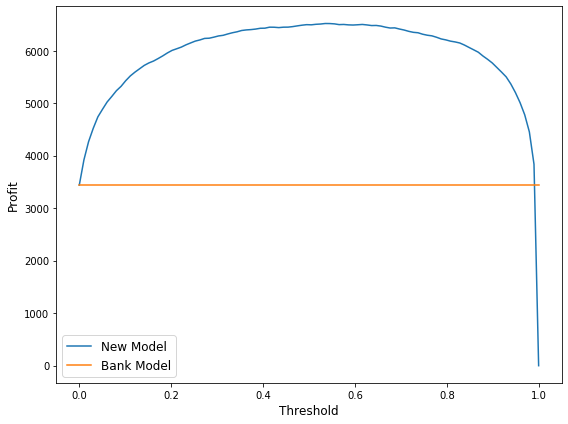

In [105]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(thresholds, profits, label='New Model')
ax.plot(thresholds, [bank_profit] * len(thresholds), label='Bank Model')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Profit', fontsize=12)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

Clearly, the new model outperforms the original model used by the bank.

### Question 2

As discussed above

### Question 3

In my model, `saving_amount` and `checking_amount` are the top two most important features.

For the `is_employed`, it is not very important in my current model. However, `is_employed` is directly related to salary. For people with no employment, their salary is 0. Since salary is also very important, we can conclude that `is_employed` is also important, but it is indirectly related to the model.

[Reference Idea](https://github.com/stasi009/TakeHomeDataChallenges/blob/master/12.LoanGrant/loan_grant.ipynb)

According to above plot, the most important feature is 'saving amount'. This makes perfect sense. Money in the saving account, meaure a person's ability to control his financial situation. More money in the saving account, more likely the borrower can repay.

As I mentioned, in my model, 'is_employed' is merged into feature 'salary', which correspond to the case 'salary=0'. according to above plot, salary is also a strong feature.

* if not employed, then salary=0, which will impact negatively on 'grant decision'. that is very easy to understand, a person without any financial input, will be very unlikely to repay.
* but even the person is employed, whether grant the loan or not, depends on his salary. higher salary indicates strong ability to repay.

### Question 4

Some useful feature which may include:

* Marriage status.
    - Because even a borrow cannot repay, if he/she is married, his/her spouse can help to repay.
* Housing status, has his/her own house, or rent appartments? if renting, how much is monthly rent?
    - Because even the borrower cannot repay, if he/she has house, the house can be sold to repay the debt
* Educational level
    - Normally a person who received higher education, has stronger capability to earn money to repay, and has higher moral standard to repay.